## notebook prep (imports, download dataset, set printouts etc.)

In [ ]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import kaggle
import zipfile
import seaborn as sns
import numpy as np
from torch import tensor
import torch
import torch.nn.functional as F
import pandas as pd
from fastai.data.transforms import RandomSplitter

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

# pre-process dataset

In [ ]:
# import training data

filename = 'train.csv'
df = pd.read_csv(path/filename)

# pre-process training data
def pre_process(df):
    df.fillna(df.mode().iloc[0], inplace=True)

    cols_original = set(df.columns)
    df['LogFare'] = np.log10(df['Fare']+1)
    def plot_LogFare():
        plt.figure(figsize=(4,2))
        df['LogFare'].hist()
        plt.title('Log (base 10) fares histogram ')
        plt.xlabel('log10(Fare)')
        plt.ylabel('# of occurences')
        plt.show()
    # plot_LogFare()

    df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked'])
    cols_added = list(x for x in df.columns if x not in cols_original)
    df[cols_added].head()
    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(int)

    # create training dependent and independent variable tensors
    cols_indep = ['Age', 'SibSp', 'Parch'] + cols_added
    indep = tensor(df[cols_indep].values, dtype=torch.float)

    # normalize independent variable values to between 0 and 1
    # (otherwise features with very high values such as age may have outsized effects)
    vals, _ = indep.max(dim=0)
    indep = indep/vals

    if 'Survived' in df.columns:
        dep = tensor(df.Survived)
        return dep, indep
    
    return indep

dep, indep = pre_process(df)

## split dataset into training and validation subsets

In [ ]:
# generate indices for training and validation sets
split_train, split_val = RandomSplitter(seed=42)(df)

# generate training and validation datasets
train_indep = indep[split_train]
train_dep = dep[split_train]
train_dep = train_dep[:, None].T

val_indep = indep[split_val]
val_dep = dep[split_val]
val_dep = val_dep[:, None].T

print(f'length of training dataset: {len(train_dep)}')
print(f'length of validation dataset: {len(val_dep)}')

length of training dataset: 1
length of validation dataset: 1


## linear model

epoch: 0; loss = 0.5120


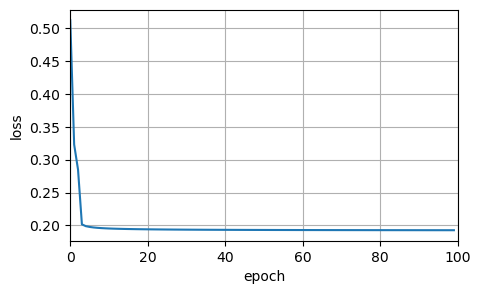

In [ ]:
coeffs = torch.rand(12, 1)-0.5
coeffs.requires_grad_()

loss_recorded = []
epochs = 100
ls = 100
for i in range(epochs):
    predictions = torch.sigmoid((train_indep@coeffs).sum(axis=1))
    loss = torch.abs(predictions-train_dep).mean()
    loss_recorded.append(float(loss))
    if i%100==0: print(f'epoch: {i}; loss = {loss:.4f}')
    loss.backward()
    with torch.no_grad():
        coeffs.sub_(coeffs.grad * ls)
        coeffs.grad.zero_()

plt.figure(figsize=(5,3))
plt.plot(loss_recorded)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.xlim((0,len(loss_recorded)))
plt.show()


In [ ]:
# calculate the accuracy on the training set
predictions = torch.sigmoid((train_indep@coeffs).sum(axis=1))
results = train_dep.bool()==(predictions>0.5)
print(f'accuracy on the training set: {results.float().mean():.4f}')

# calculate the accuracy on the validation set
predictions = torch.sigmoid((val_indep@coeffs).sum(axis=1))
results = val_dep.bool()==(predictions>0.5)
print(f'accuracy on the validation set: {results.float().mean():.4f}')

accuracy on the training set: 0.8079
accuracy on the validation set: 0.8258


In [ ]:
test_df = pd.read_csv(path/'test.csv')
test_indep = pre_process(test_df)
test_indep.shape

predictions = torch.sigmoid((test_indep@coeffs).sum(axis=1))
test_df['Survived'] = (predictions>0.5).int()

In [ ]:
submission_df = test_df[['PassengerId','Survived']]
submission_df.head(n=20)
submission_df.to_csv('sub.csv', index=False)

## neural network

In [ ]:
def train_model(dep, indep, epochs=30, lr=20):
    torch.manual_seed(442)
    n_coeffs = indep.shape[1]
    
    def init_coeffs(n_coeffs, n_hidden=20):
        layer1 = (torch.rand(n_coeffs, n_hidden)-0.5)/n_hidden
        layer2 = torch.rand(n_hidden, 1)-0.3
        const = torch.rand(1)[0]
        coeffs = (layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_())
        return coeffs
    coeffs = init_coeffs(n_coeffs)

    for i in range(epochs):

        def one_epoch(dep, indep, coeffs,lr):

            def calc_loss(dep, indep, coeffs):
                def calc_preds(indep, coeffs):
                    l1,l2,const = coeffs
                    res = F.relu(indep@l1)
                    res = res@l2 + const
                    return torch.sigmoid(res)
                return torch.abs(calc_preds(indep, coeffs)-dep).mean()
            loss = calc_loss(dep, indep, coeffs)

            loss.backward()
            with torch.no_grad():
                # update coefficients function
                for layer in coeffs:
                    layer.sub_(layer.grad * lr)
                    layer.grad.zero_()
            if i % 10 == 0 or i == epochs-1:
                print(f'epoch: {i}; loss: {loss:.4f}')
        one_epoch(dep, indep, coeffs, lr=lr)
    
    return coeffs

train_dep = train_dep.T
val_dep = val_dep.T
coeffs = train_model(train_dep, train_indep)


def calc_preds(indep, coeffs):
    l1,l2,const = coeffs
    res = F.relu(indep@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

def acc(coeffs):
    return (val_dep.bool()==(calc_preds(val_indep, coeffs)>0.5)).float().mean()
acc(coeffs)

# l1, l2, const = coeffs

epoch: 0; loss: 0.5436
epoch: 10; loss: 0.1935
epoch: 20; loss: 0.1928
epoch: 29; loss: 0.1926


tensor(0.8258)

## deep learning